In [93]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score

%matplotlib inline

# a function to draw a plot of an SVM
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    sv = svc.support_vectors_
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

In [105]:
landmarks = pd.read_csv('./data/landmark_AT_filled_w_median.csv')
landmarks.head()

,Unnamed: 0,sample_index,min_alpha,max_alpha,min_theta,max_theta,num,pts,r,stype,unique_key,landmark_index
0,0,1,-90.51,-80.99,-3.14,-2.36,50,0,0.000000,mt-at,28.82484076,1
1,80,1,-90.51,-80.99,-2.36,-1.57,50,0,0.000000,mt-at,38.35169492,2
2,160,1,-90.51,-80.99,-1.57,-0.79,50,0,0.000000,mt-at,57.64968153,3
3,240,1,-90.51,-80.99,-0.79,0.00,50,0,7.063969,mt-at,114.5696203,4
4,320,1,-90.51,-80.99,0.00,0.79,50,0,7.188517,mt-at,#DIV/0!,5


In [106]:
# fixing 112
landmarks.sample_index = landmarks.sample_index.astype(str)
for i, row in landmarks.iterrows():
    if row.sample_index=='112':
        if row.stype == row.stype=='wt-at':
            landmarks.set_value(i,'sample_index','112_1')
        else:
            landmarks.set_value(i,'sample_index','112_2')

/Users/dejiatang/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
/Users/dejiatang/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


In [88]:
r_medians_wt = []
r_medians_mt = []
landmarks.pts = landmarks.pts.astype(float)
landmarks.r = landmarks.r.astype(float)
max_landmark = np.max(landmarks.landmark_index)
for i in range(1,max_landmark+1):
    chosenLandmark = landmarks[landmarks.landmark_index==i]
    chosenLandmark_no_na = chosenLandmark[chosenLandmark.pts != 0]
    
    chosenLandmark_no_na_wt = chosenLandmark_no_na[chosenLandmark.stype == 'wt-at']
    na_fill_wt = 0 if chosenLandmark_no_na_wt.shape[0]==0 else np.median(chosenLandmark_no_na_wt.r)
    r_medians_wt.append(na_fill_wt)
    
    chosenLandmark_no_na_mt = chosenLandmark_no_na[chosenLandmark.stype == 'mt-at']
    na_fill_mt = 0 if chosenLandmark_no_na_mt.shape[0]==0 else np.median(chosenLandmark_no_na_mt.r)
    r_medians_mt.append(na_fill_mt)

/Users/dejiatang/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/dejiatang/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/dejiatang/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [89]:
# fill in missing values
for i, row in landmarks.iterrows():
    if row.pts==0:
        median = r_medians_wt[row.landmark_index-1] if row.stype=='wt-at' else r_medians_mt[row.landmark_index-1]
        #print(row.stype, median, row.landmark_index)
        landmarks.set_value(i,'r',r_medians[row.landmark_index-1])

/Users/dejiatang/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [107]:
landmarks.to_csv('./data/landmark_AT_filled_w_median.csv', sep=',')

## SVM Method 

In [97]:
def svm_classification(landmarks, index):
    # filter out the landmarks needed
    chosenLandmark = landmarks[landmarks.landmark_index==index]
    
    # create training and testing data
    X = chosenLandmark[['pts', 'r']]
    y = chosenLandmark['stype']
    y = y.replace(['mt-at'], 1)
    y = y.replace(['wt-at'], 0)
    
    # present the data
    plt.figure(figsize=(8, 5))
    plt.scatter(X.values[:,0], X.values[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    
    # find the best C value by cross-validation
    '''tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100, 1000]}]
    clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=10, scoring='accuracy')
    clf.fit(X.values, y.values)
    best_c = clf.best_params_['C']
    
    svc = SVC(C=best_c, kernel='linear')
    svc.fit(X, y)
    
    plot_svc(svc, X.values, y)
    
    prediction = svc.predict(X)
    # print confusion matrix
    print("confusion matrix: ")
    cm = confusion_matrix(y, prediction)
    cm_df = pd.DataFrame(cm.T, index=svc.classes_, columns=svc.classes_)
    print(cm_df)
    print('Classification Report: ')
    print(classification_report(y, 
                            prediction,
                            digits = 3))
    # print accuracy score
    print('Classification Accuracy: ')
    accuracy = f1_score(y, prediction)
    print(accuracy)
    
    return svc, accuracy'''

## Testing SVM Method 

index: 1


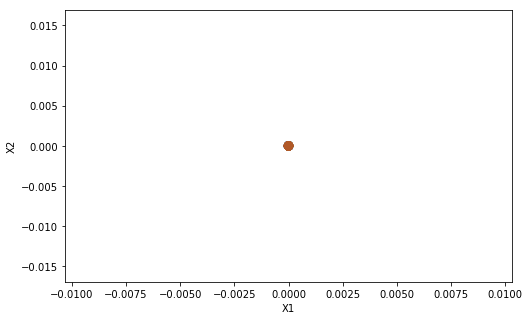

index: 2


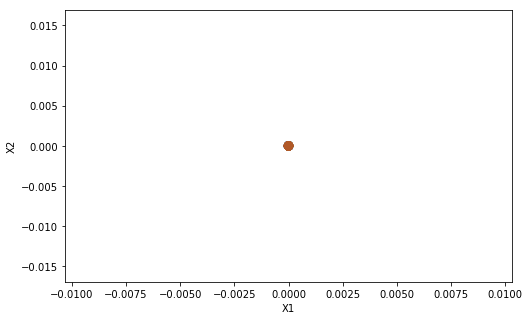

index: 3


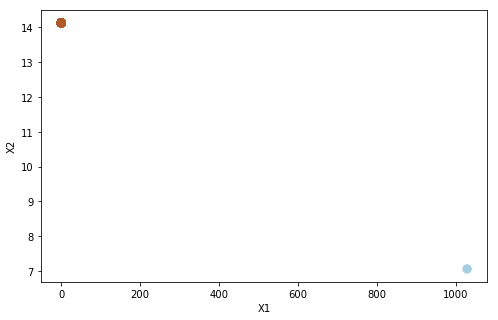

index: 4


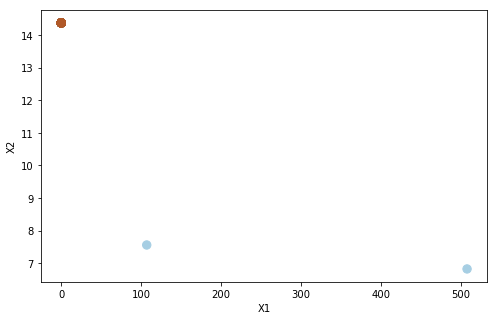

index: 5


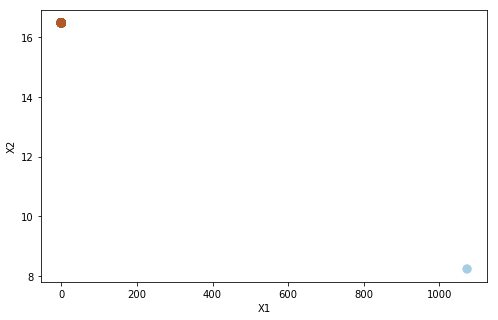

index: 6


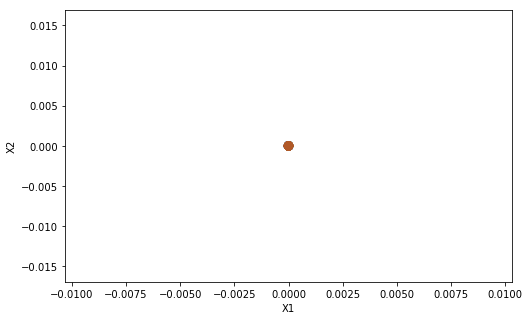

index: 7


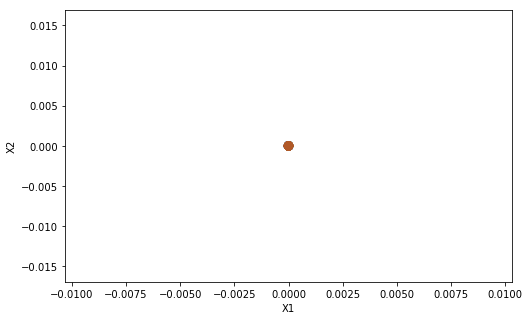

index: 8


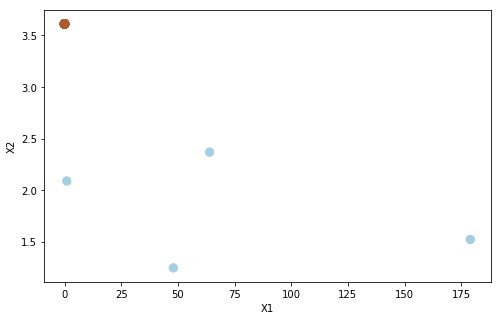

index: 9


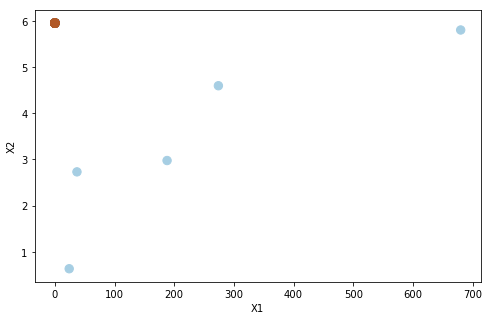

index: 10


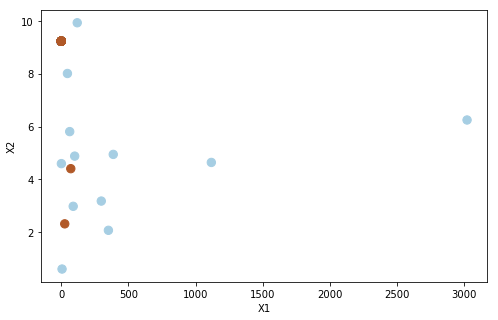

index: 11


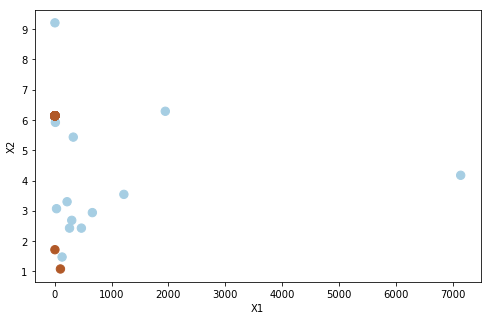

index: 12


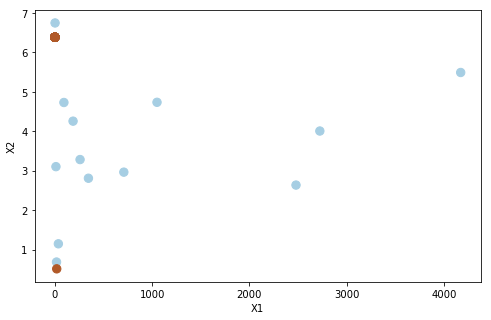

index: 13


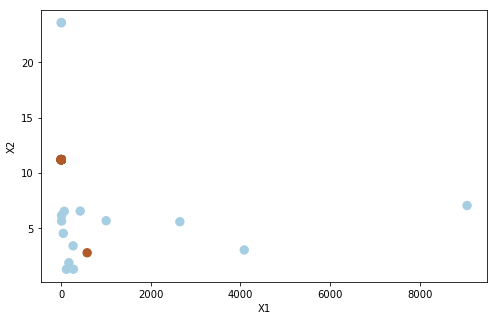

index: 14


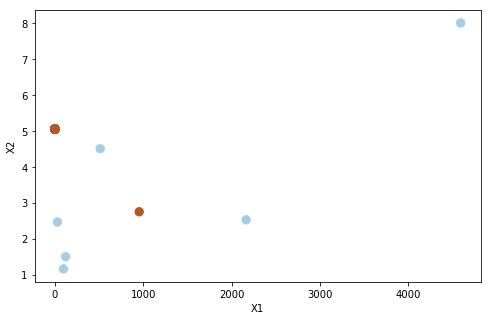

index: 15


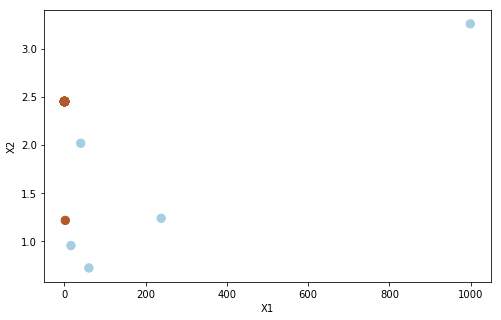

index: 16


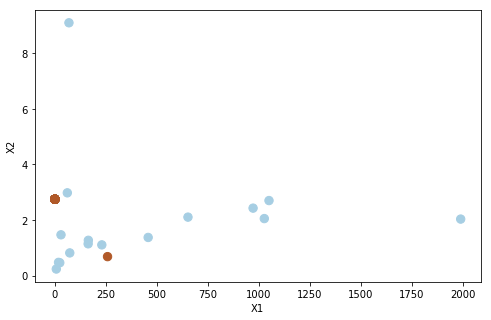

index: 17


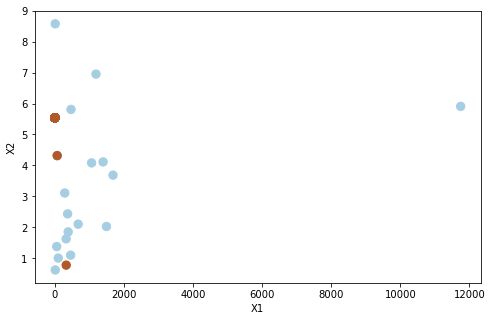

index: 18


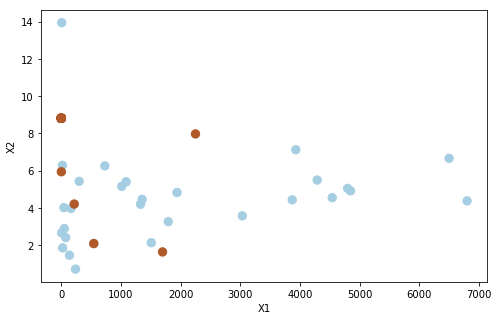

index: 19


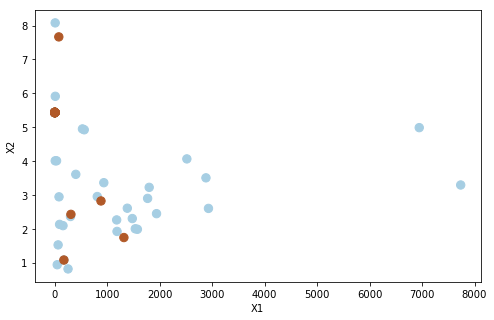

index: 20


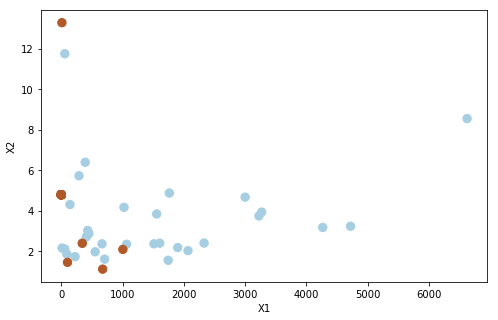

index: 21


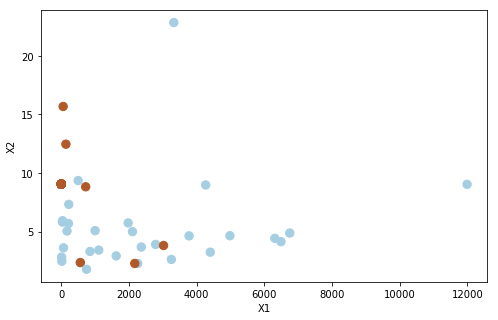

index: 22


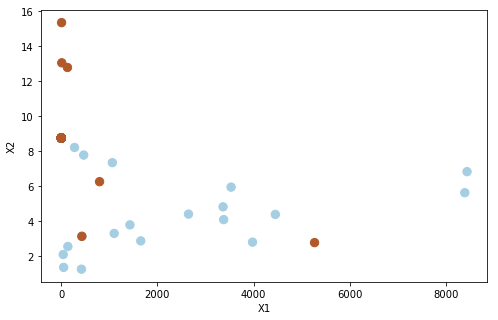

index: 23


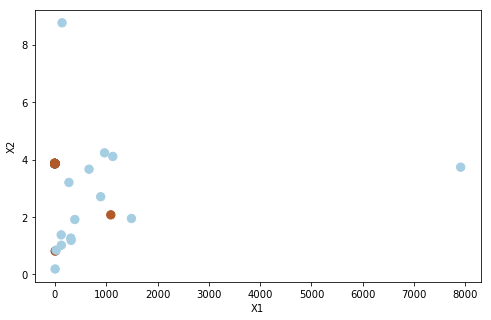

index: 24


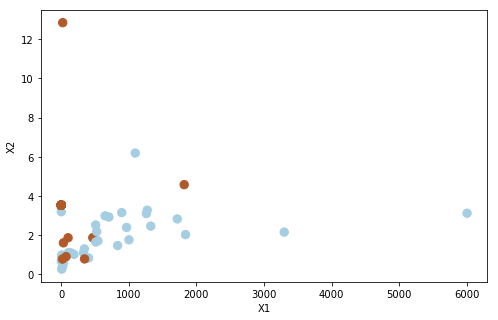

index: 25


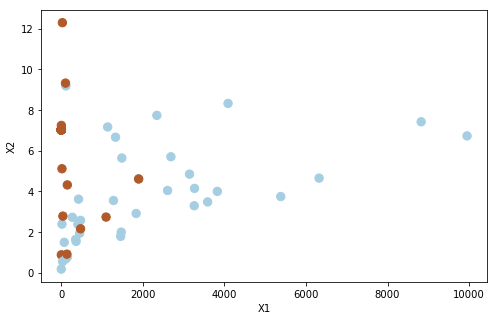

index: 26


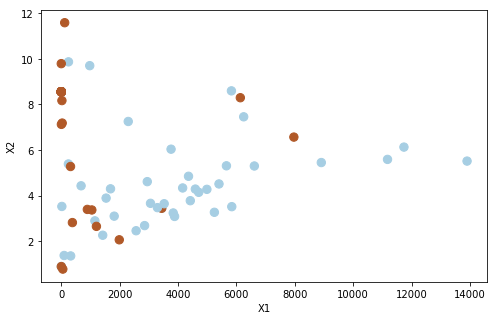

index: 27


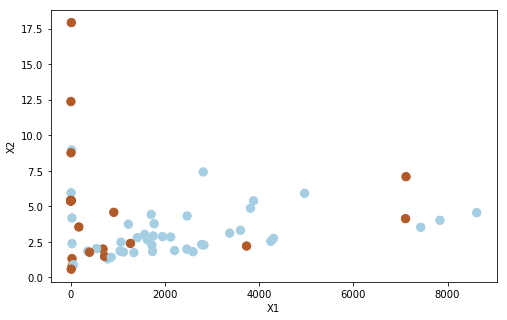

index: 28


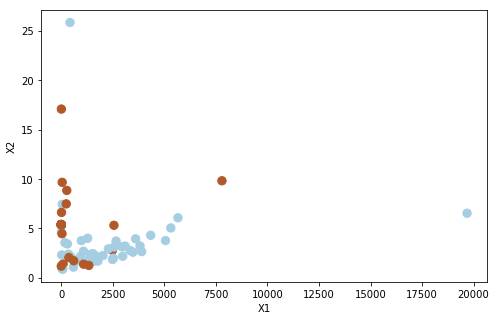

index: 29


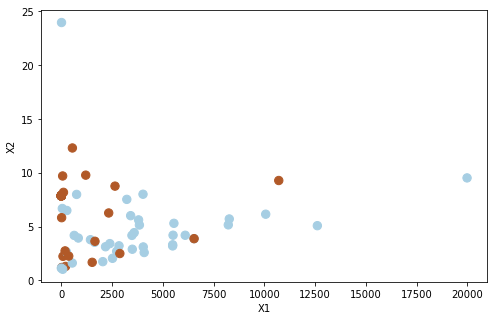

index: 30


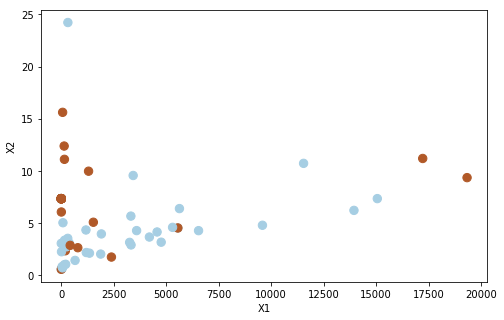

index: 31


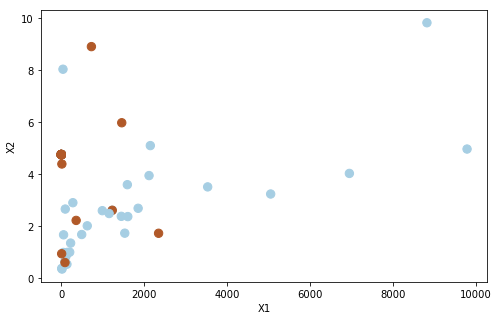

index: 32


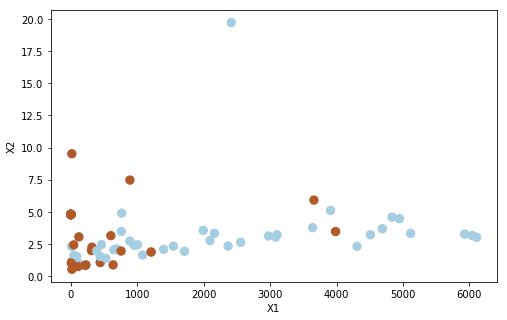

index: 33


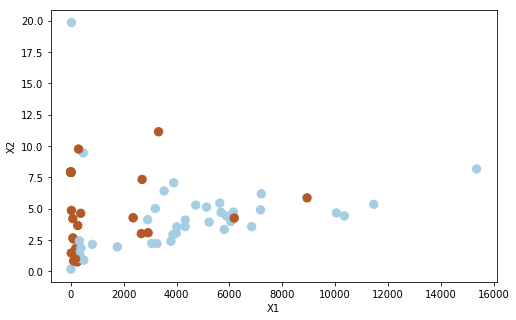

index: 34


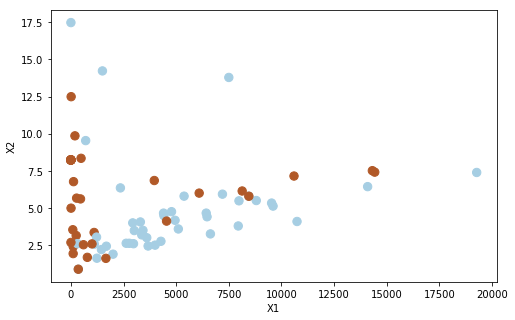

index: 35


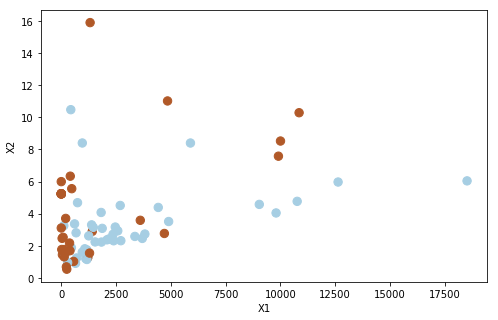

index: 36


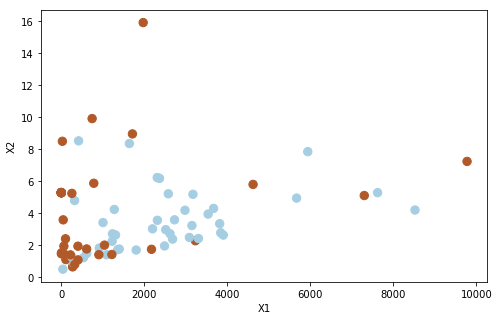

index: 37


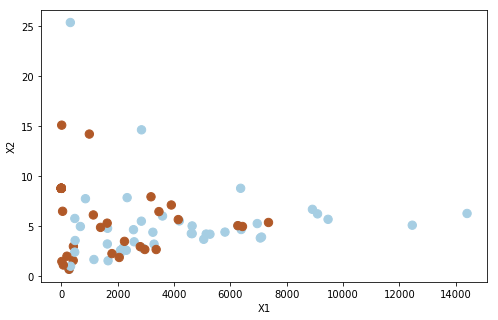

index: 38


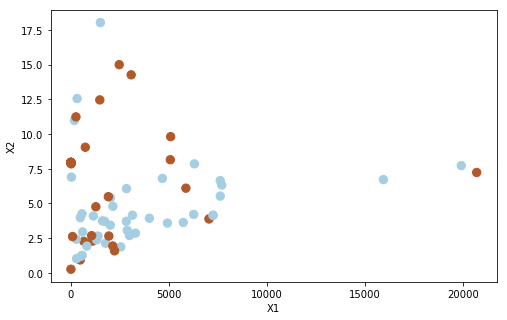

index: 39


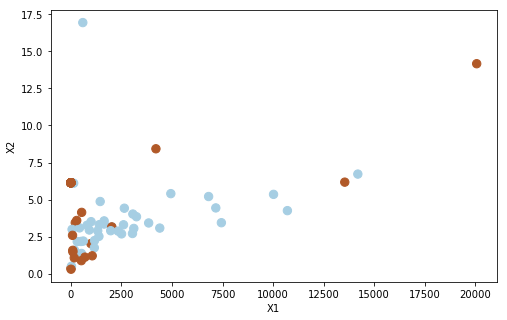

index: 40


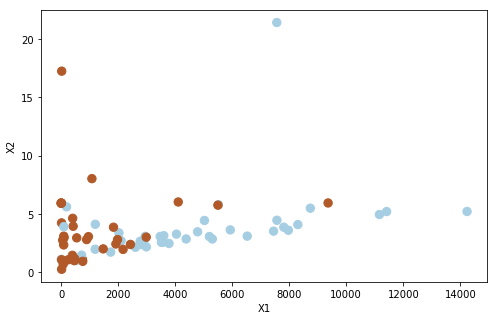

index: 41


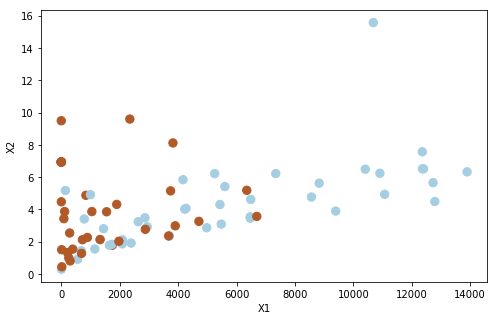

index: 42


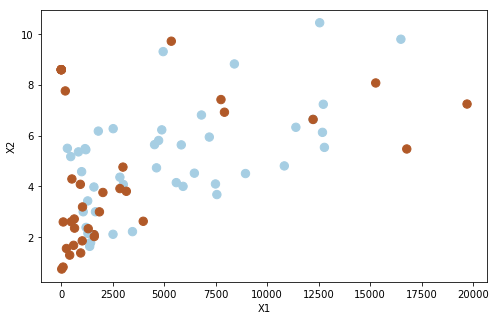

index: 43


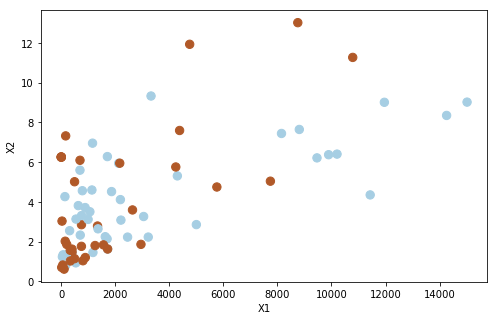

index: 44


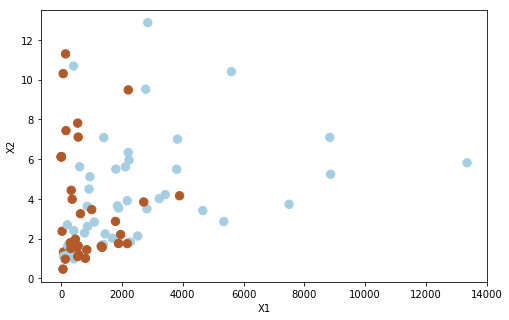

index: 45


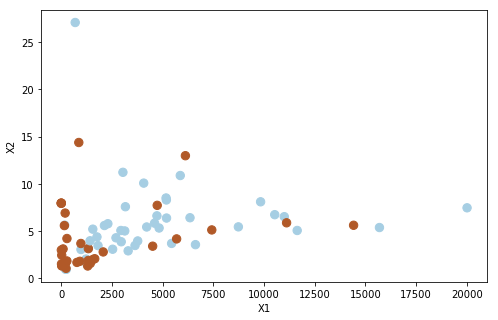

index: 46


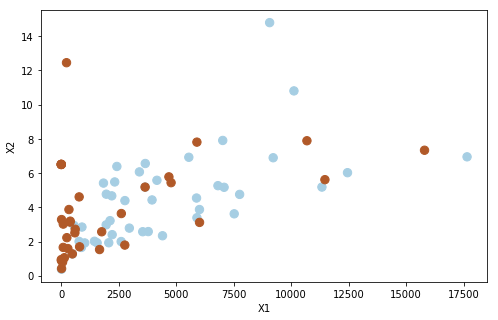

index: 47


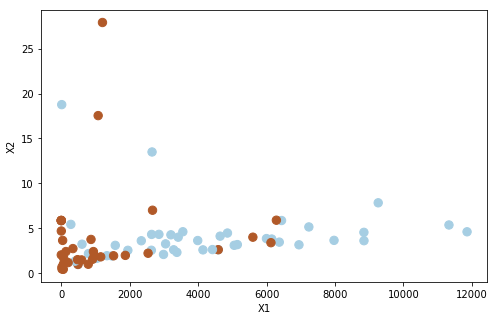

index: 48


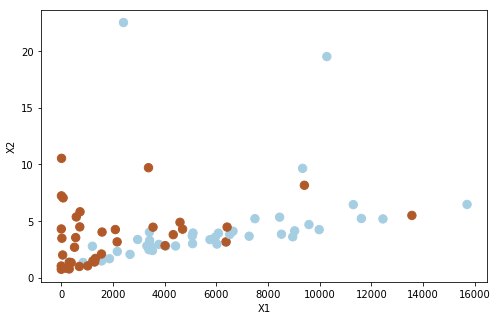

index: 49


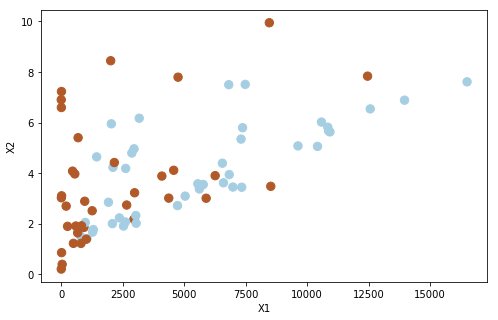

index: 50


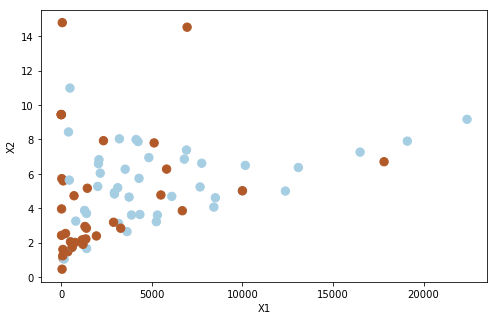

index: 51


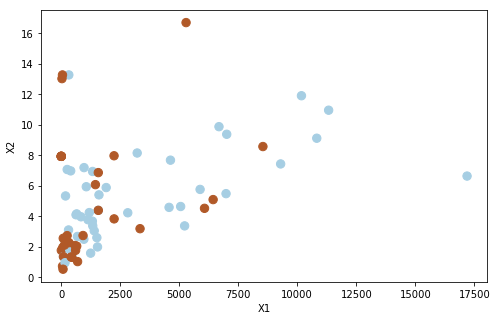

index: 52


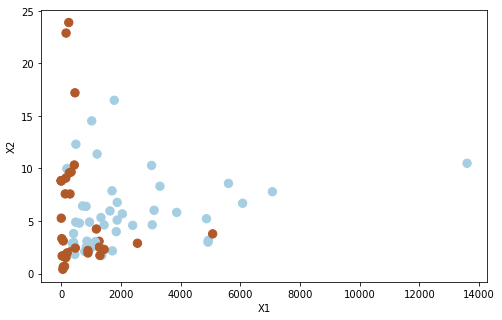

index: 53


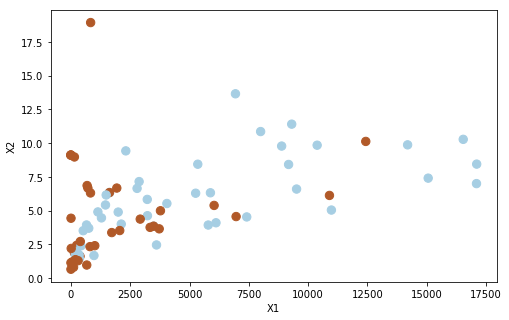

index: 54


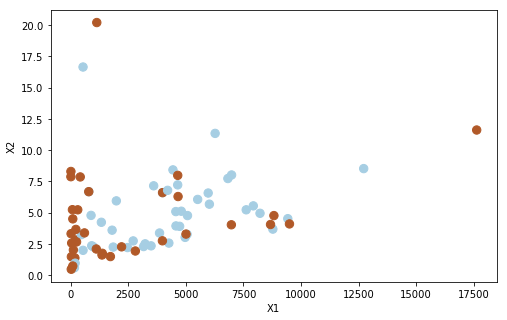

index: 55


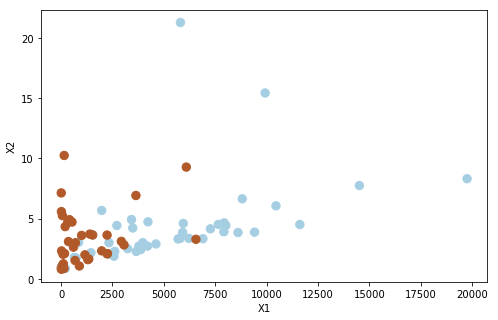

index: 56


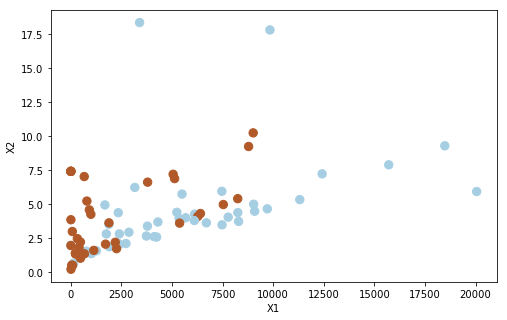

index: 57


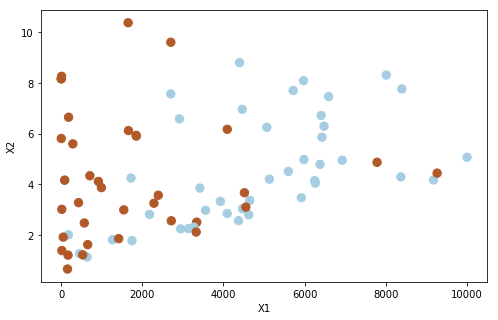

index: 58


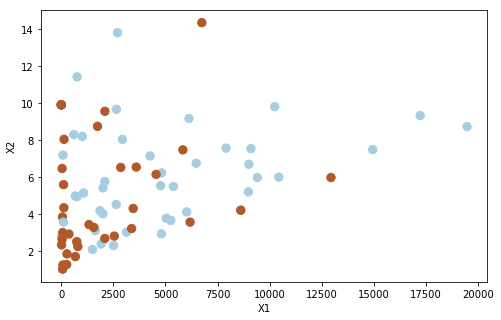

index: 59


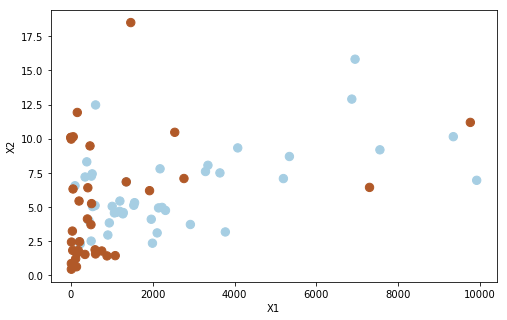

index: 60


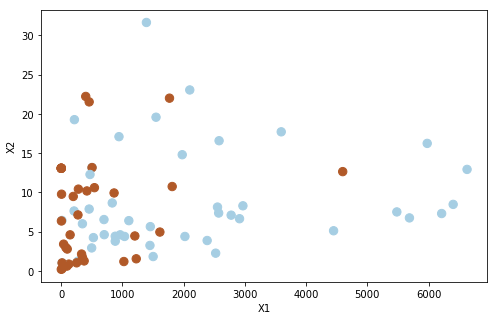

index: 61


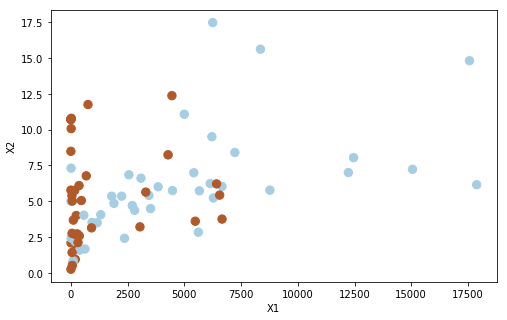

index: 62


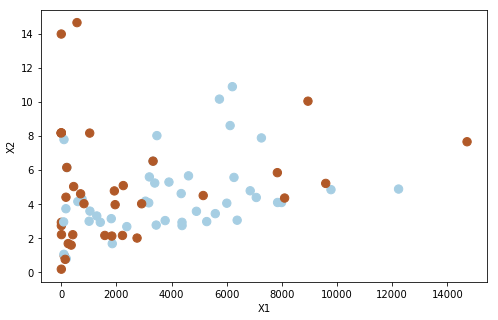

index: 63


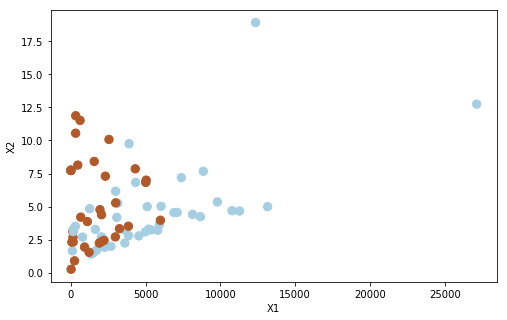

index: 64


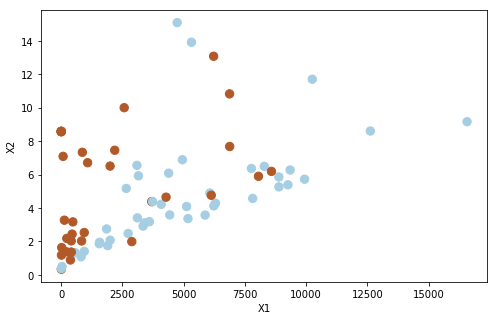

index: 65


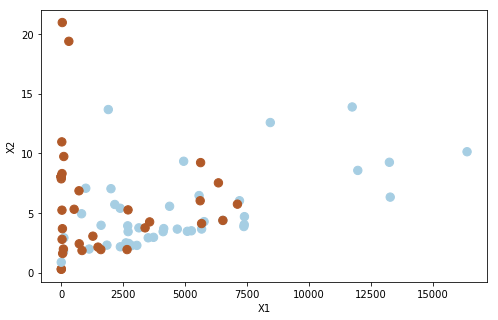

index: 66


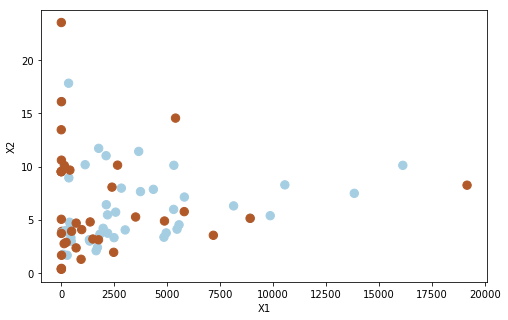

index: 67


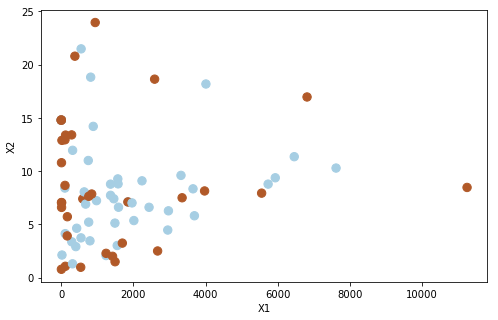

index: 68


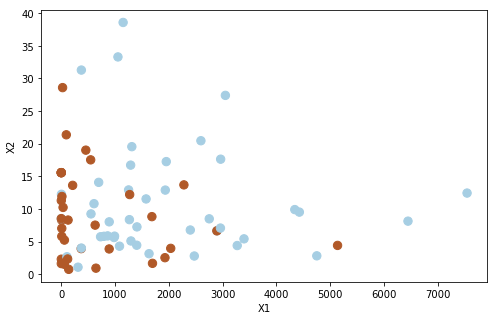

index: 69


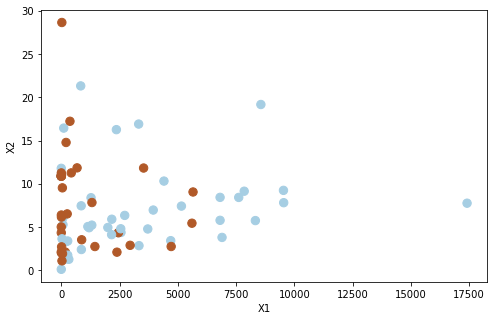

index: 70


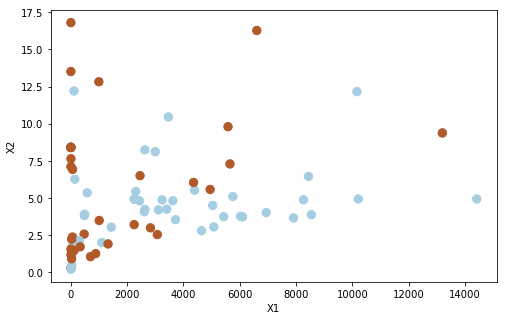

index: 71


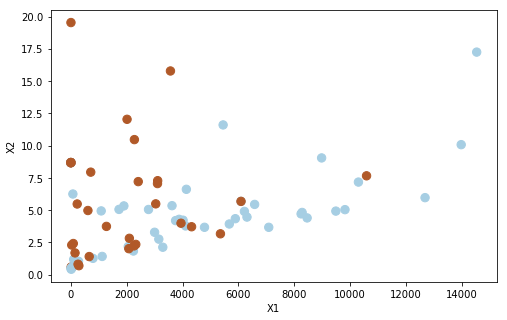

index: 72


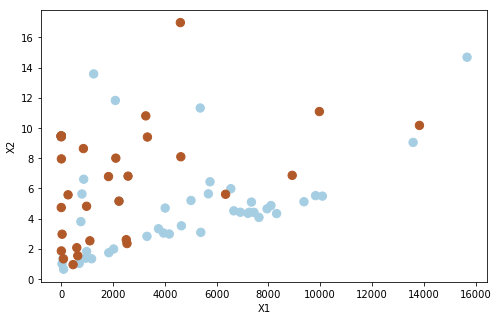

index: 73


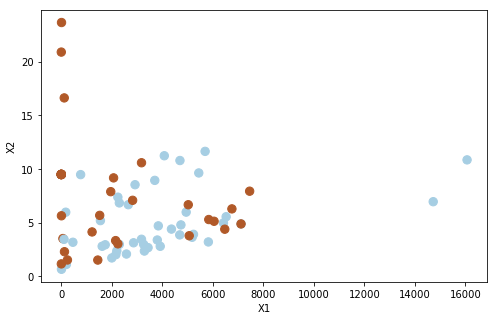

index: 74


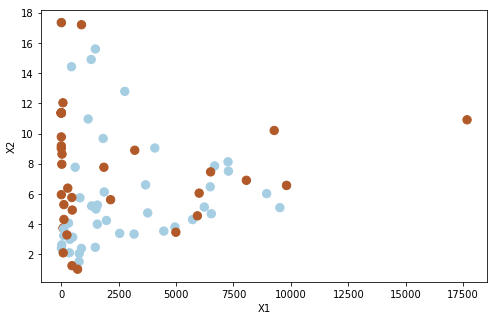

index: 75


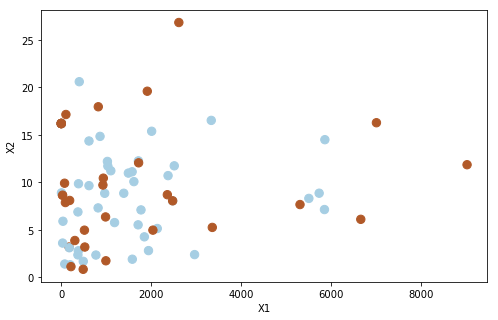

index: 76


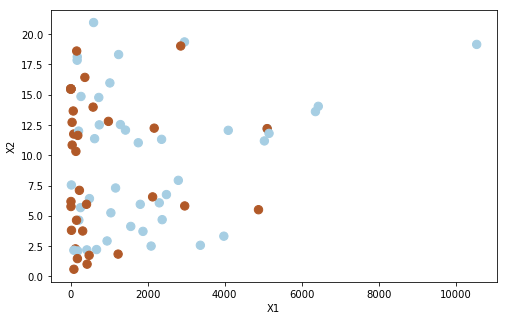

index: 77


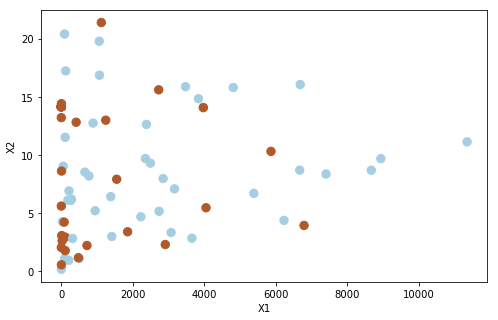

index: 78


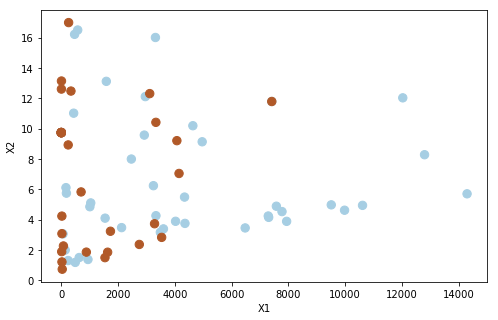

index: 79


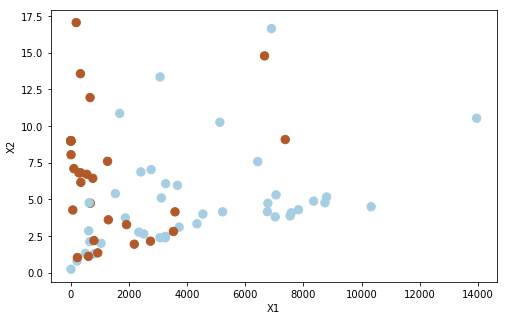

index: 80


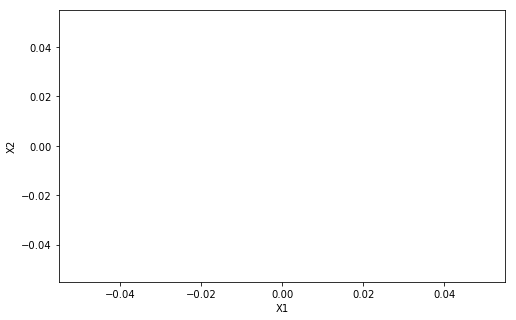

index: 81


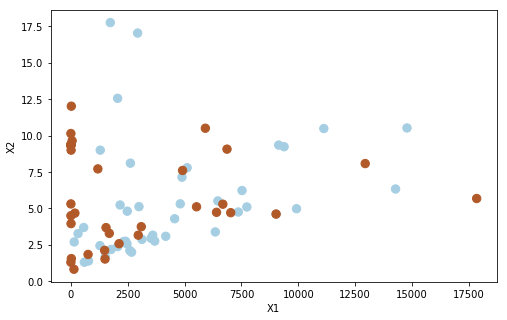

index: 82


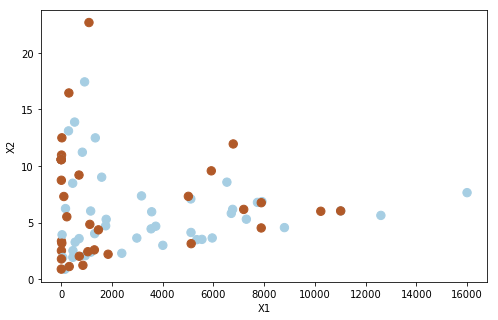

index: 83


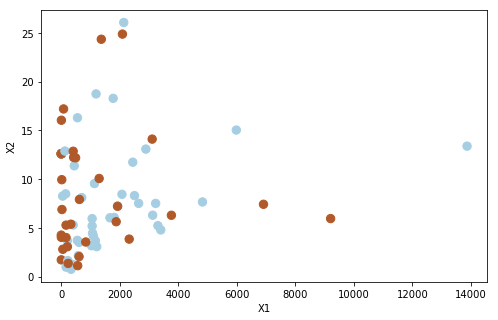

index: 84


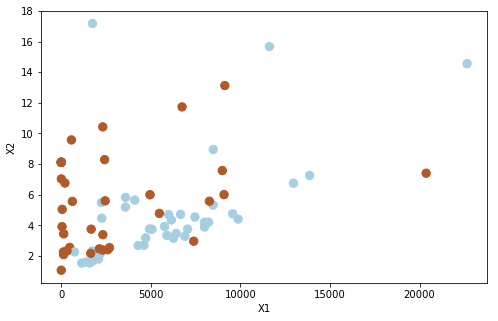

index: 85


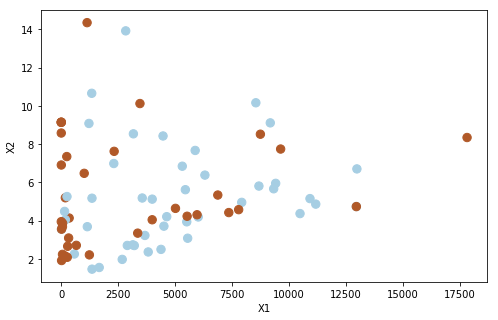

index: 86


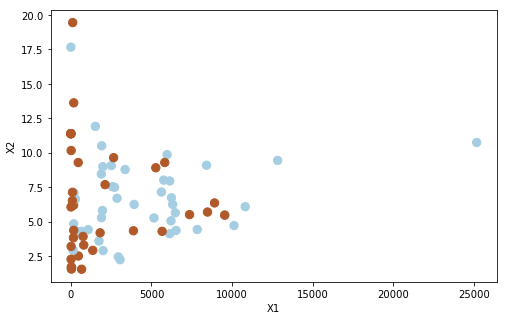

index: 87


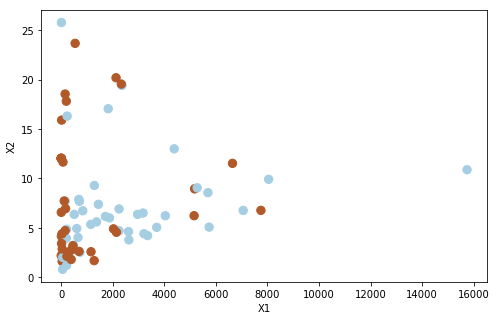

index: 88


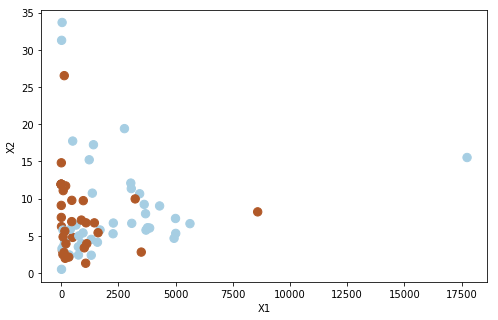

index: 89


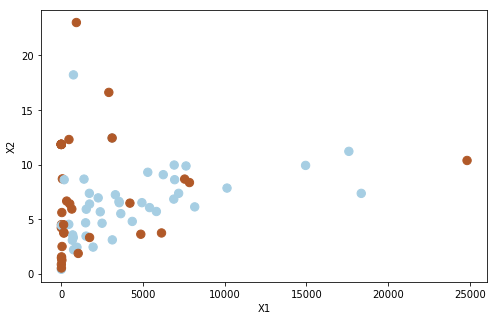

index: 90


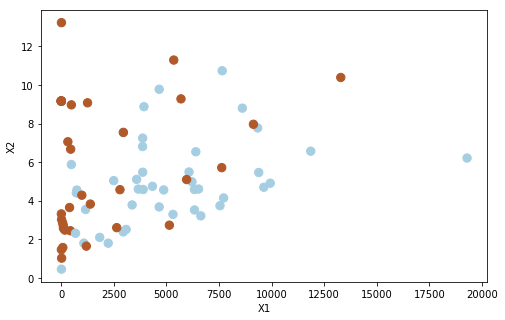

index: 91


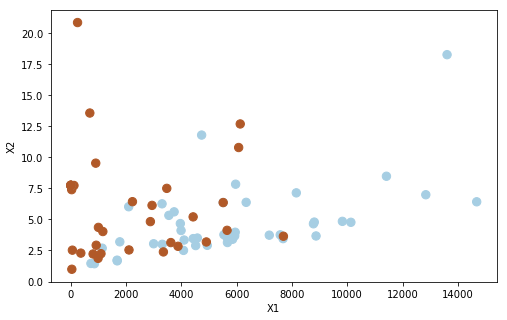

index: 92


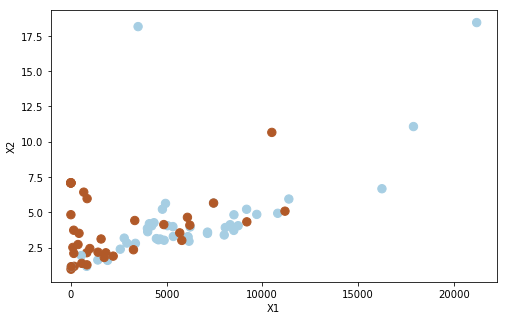

index: 93


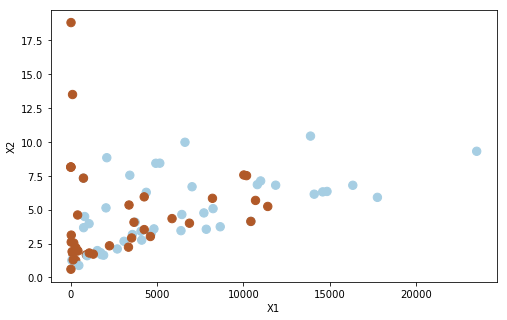

index: 94


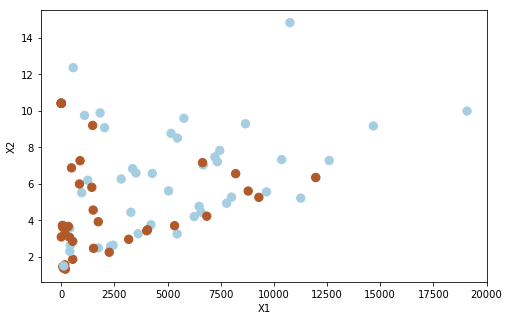

index: 95


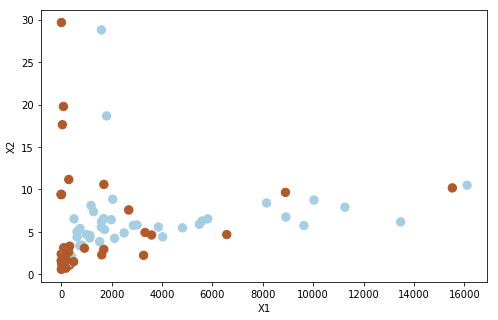

index: 96


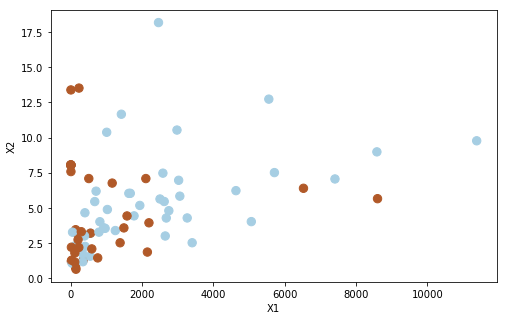

index: 97


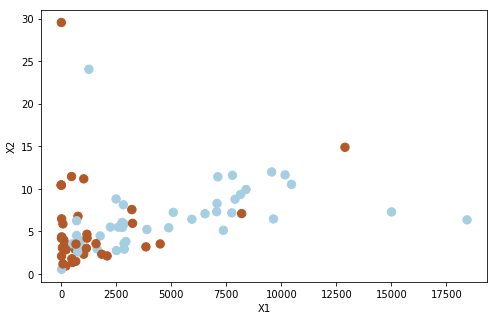

index: 98


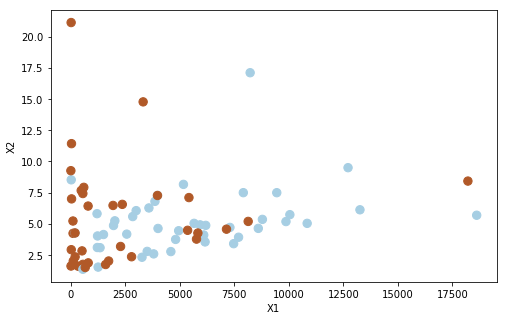

index: 99


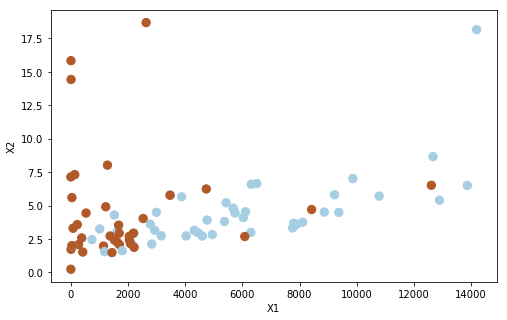

index: 100


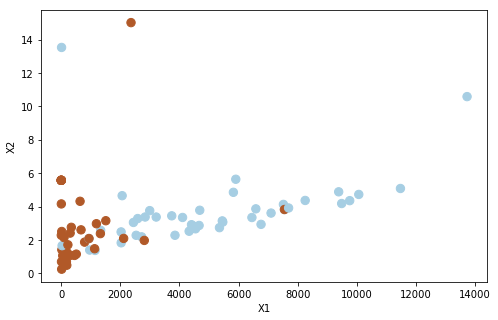

index: 101


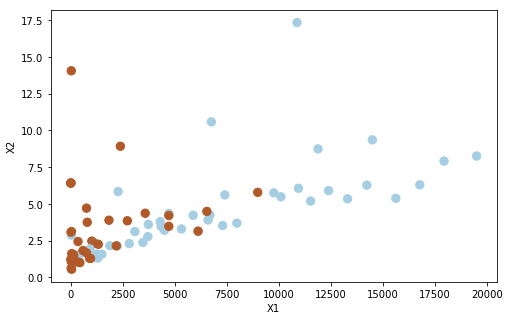

index: 102


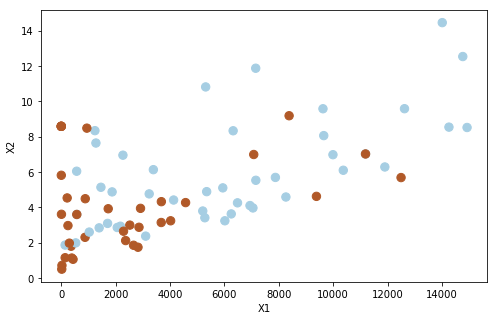

index: 103


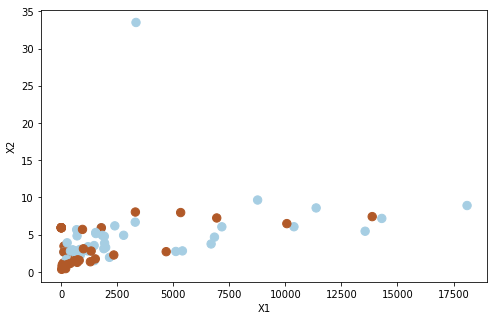

index: 104


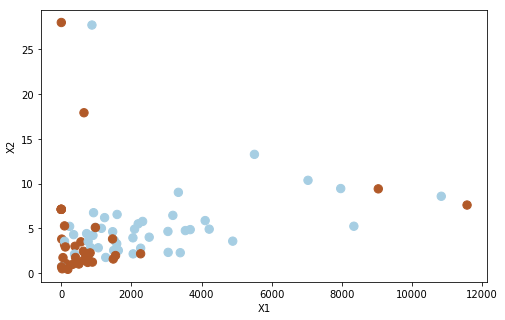

index: 105


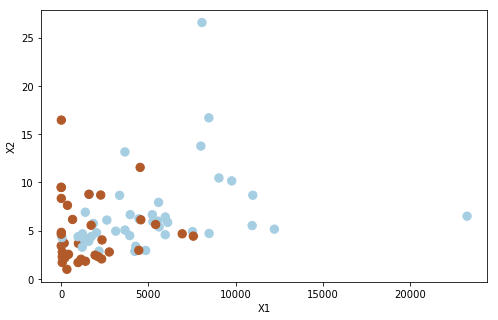

index: 106


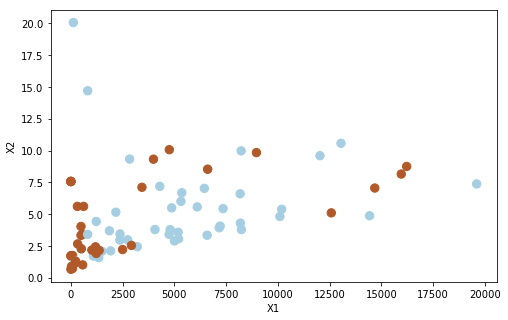

index: 107


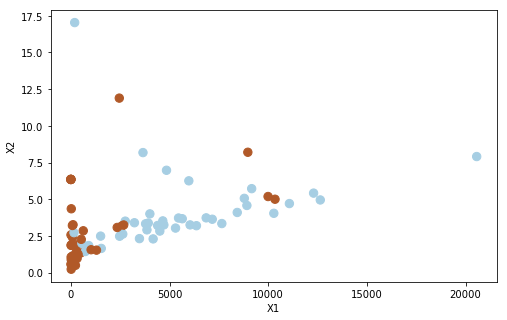

index: 108


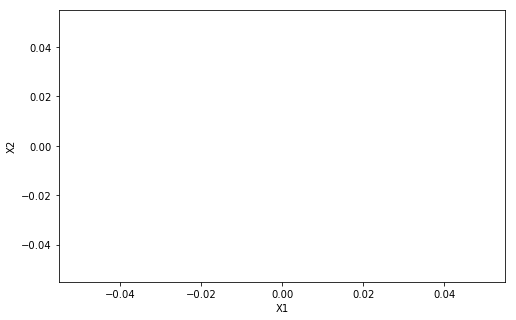

index: 109


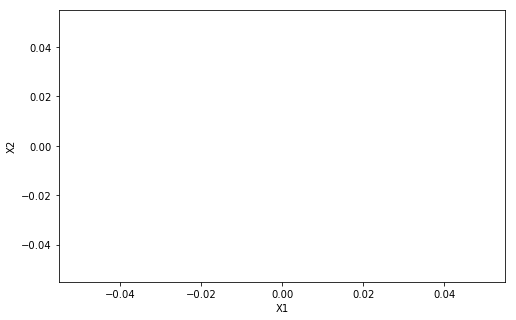

index: 110


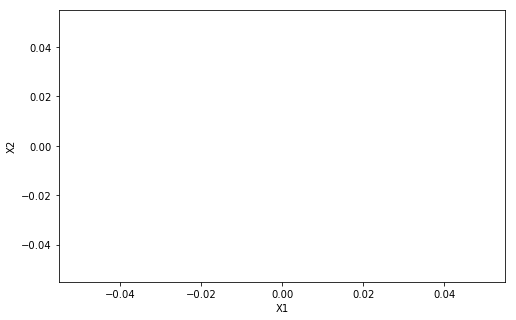

index: 111


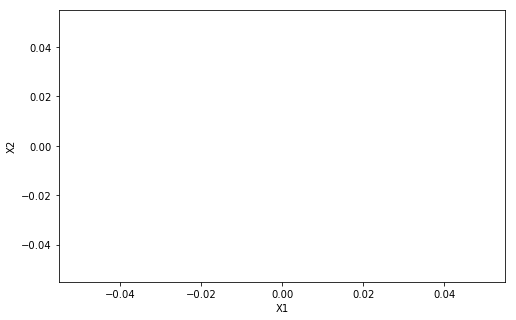

index: 112


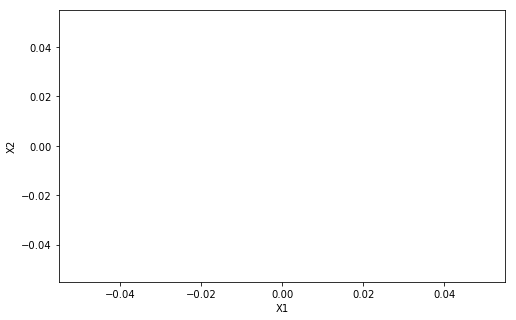

index: 113


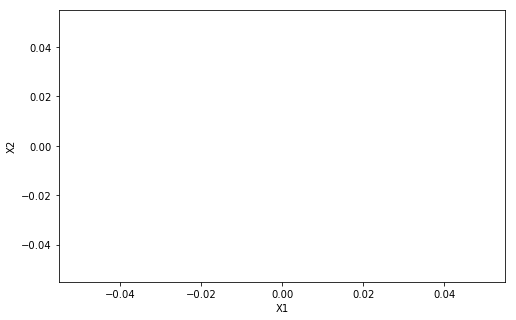

index: 114


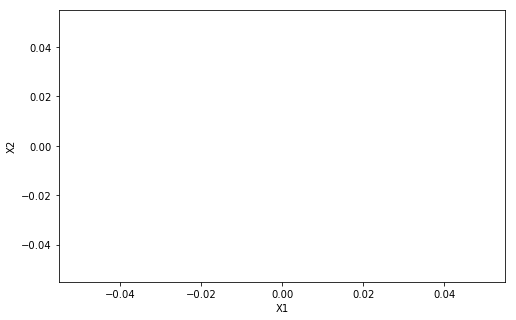

index: 115


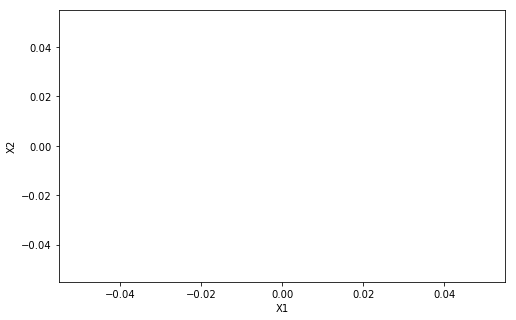

index: 116


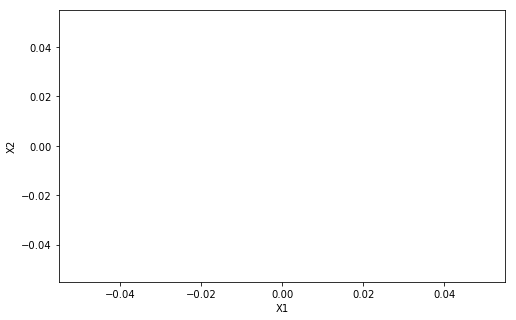

index: 117


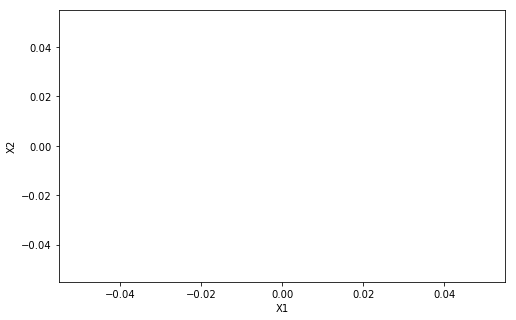

index: 118


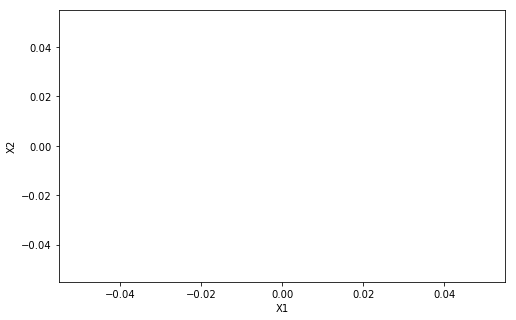

index: 119


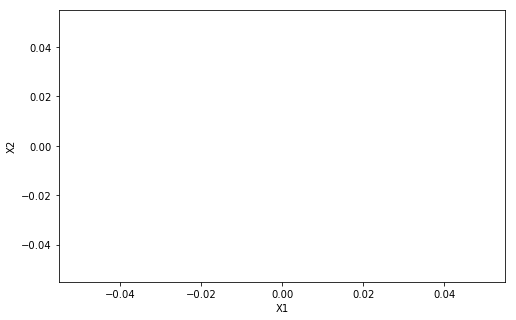

index: 120


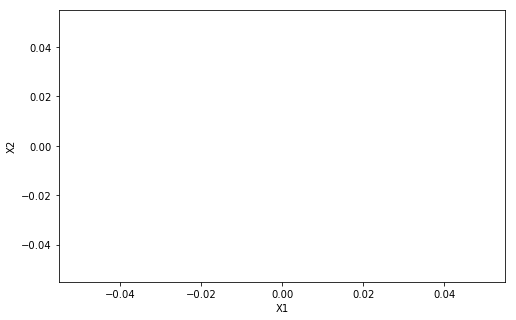

index: 121


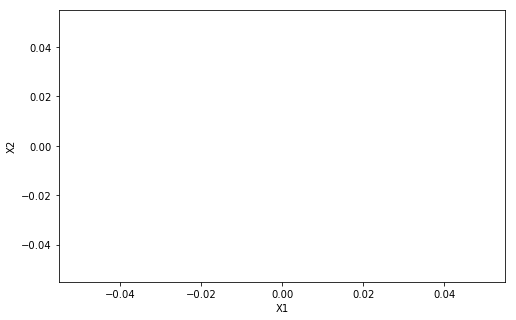

index: 122


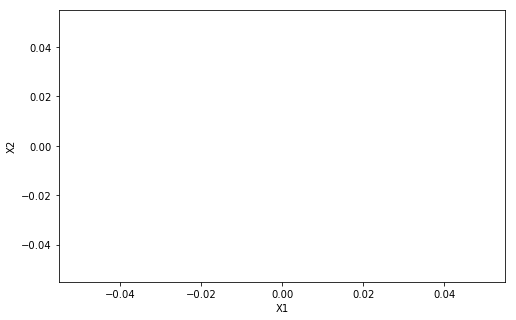

index: 123


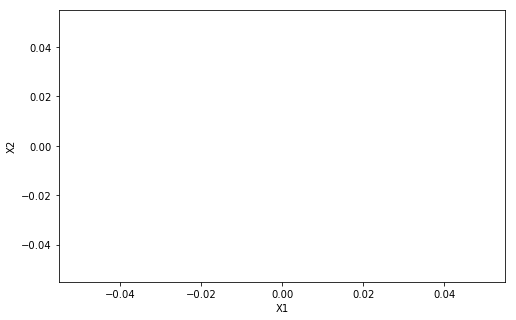

index: 124


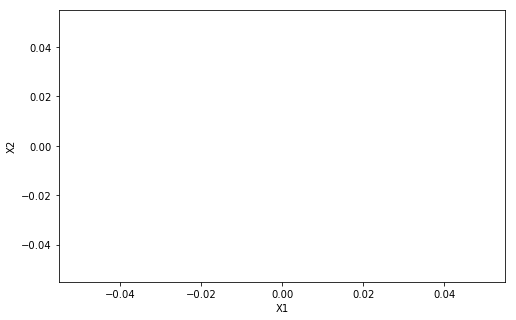

index: 125


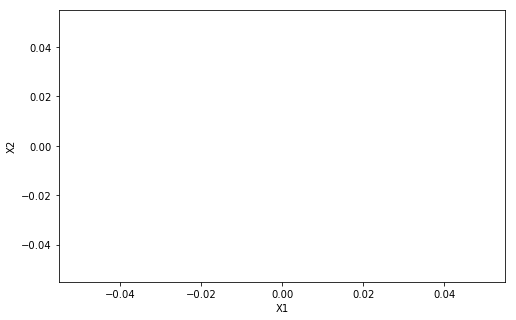

index: 126


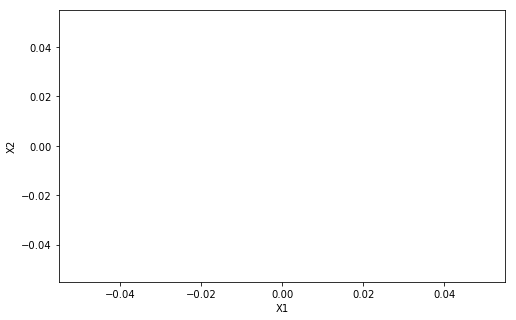

index: 127


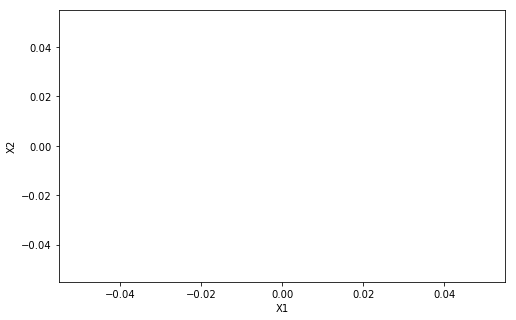

index: 128


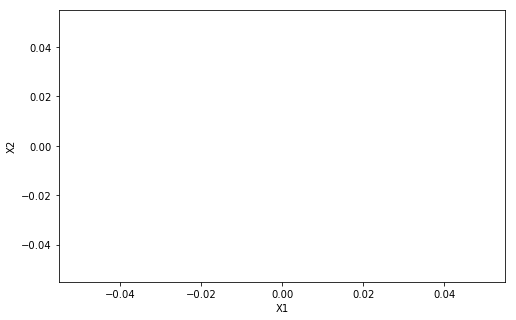

index: 129


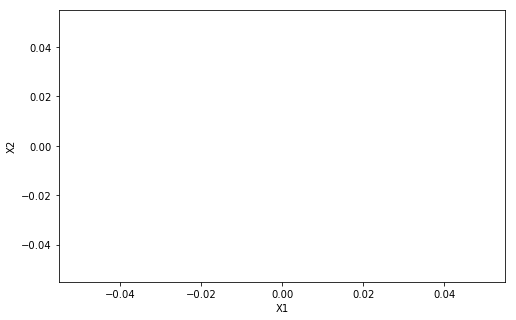

index: 130


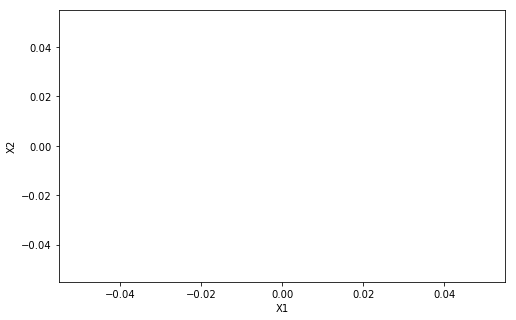

index: 131


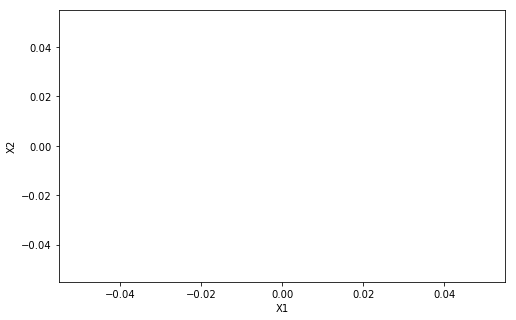

index: 132


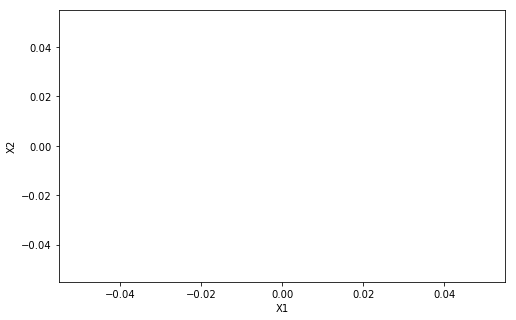

index: 133


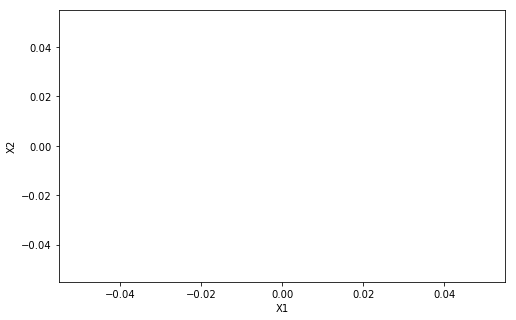

index: 134


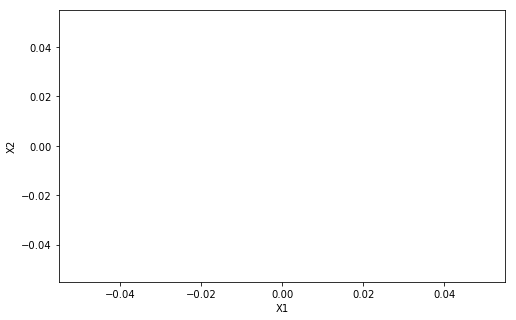

index: 135


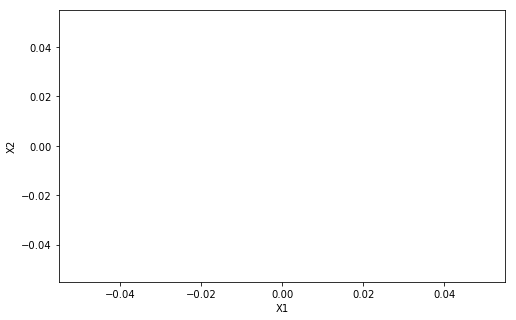

index: 136


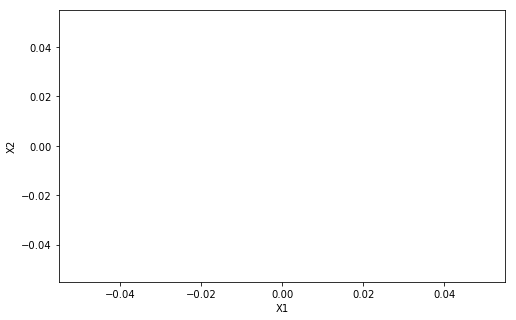

index: 137


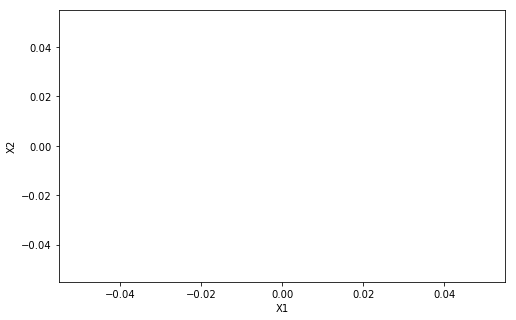

index: 138


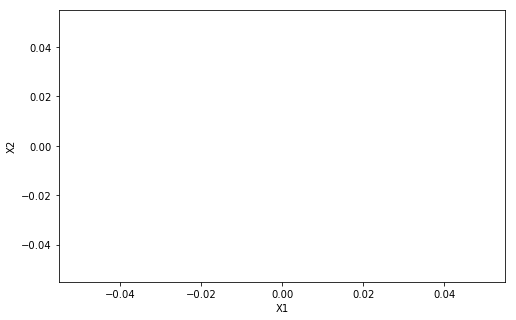

index: 139


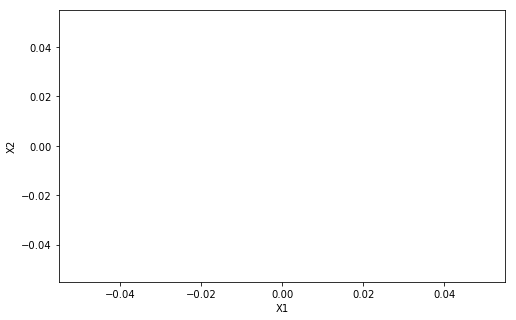

index: 140


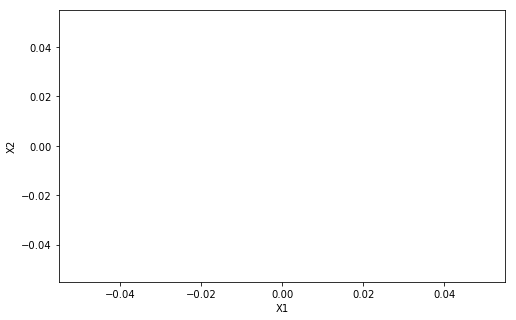

index: 141


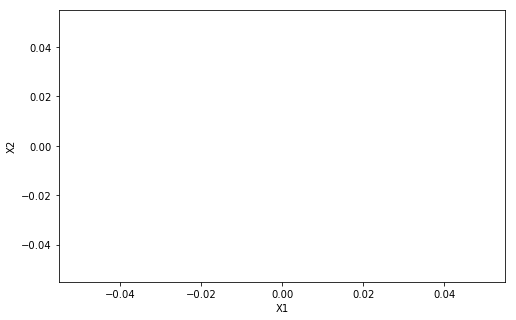

index: 142


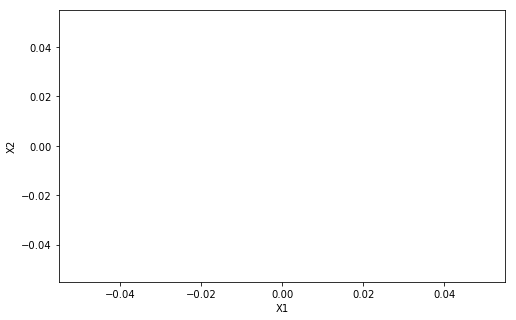

index: 143


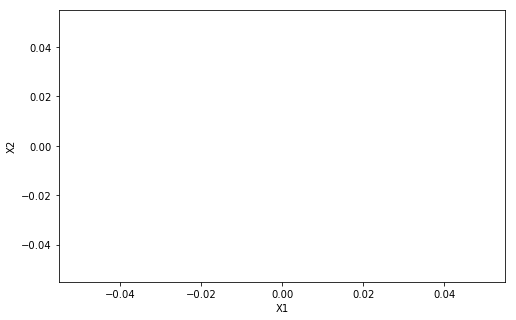

index: 144


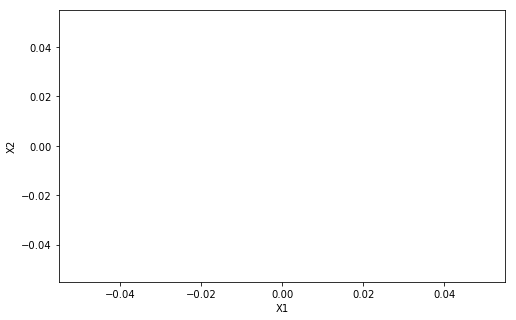

index: 145


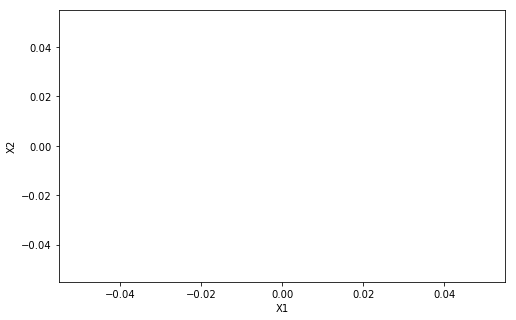

index: 146


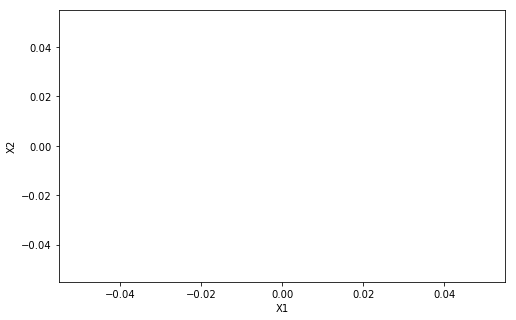

index: 147


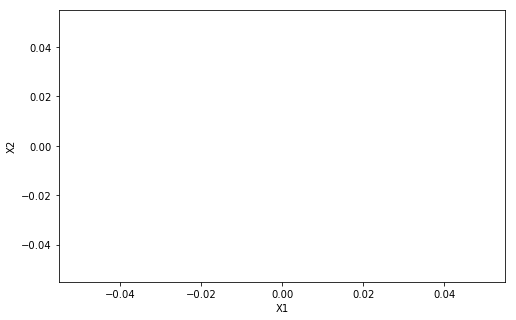

index: 148


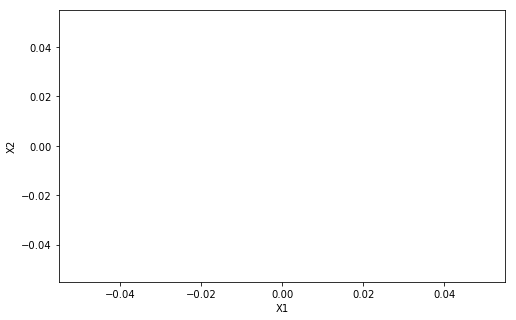

index: 149


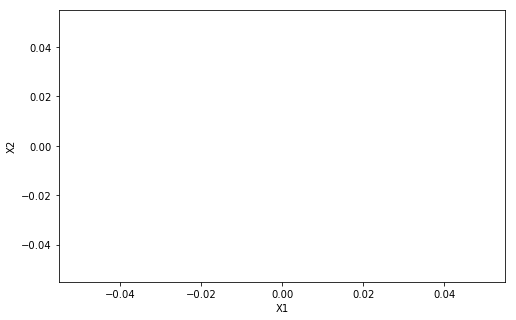

index: 150


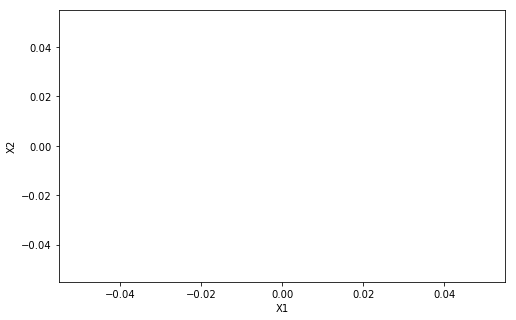

index: 151


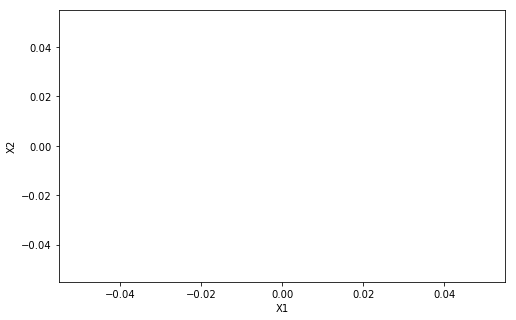

In [100]:
for i in range(1,152):
    print("index: " + str(i))
    svm_classification(landmarks, i+1)
    #svc, accuracy = svm_classification(landmarks, i+1)
    #print(accuracy)

### Testing One Sample

In [85]:
sample_1 = landmarks[landmarks.sample_index=='112_1']
sample_1 = sample_1[np.isfinite(sample_1['r'])]
landmarks_1 = sample_1['landmark_index']

In [ ]:
results = []
for l in landmarks_1.values:
    print ("landmark: ", str(l))
    svc, accuracy = svm_classification(landmarks[landmarks.sample_index!=1], l)
    prediction = svc.predict(sample_1[sample_1.landmark_index==1][['pts', 'r']])
    results.append((l, prediction[0], accuracy))
    print(results)

In [1]:
r = [(1, 0, 0.5333333333333333), (2, 1, 0.8), (3, 0, 0.4285714285714285), (4, 0, 0.8461538461538461), (5, 0, 0.47058823529411764), (6, 0, 0.6363636363636364), (7, 0, 0.4), (8, 0, 0.8275862068965518), (9, 0, 0.6666666666666665), (10, 0, 0.5714285714285714), (11, 0, 0.625), (12, 0, 0.8571428571428571), (13, 0, 0.0), (14, 0, 0.7857142857142857), (15, 0, 0.5555555555555556), (16, 0, 0.7741935483870968), (17, 0, 0.4285714285714285), (18, 0, 0.6428571428571429), (19, 0, 0.6666666666666665), (20, 0, 0.7692307692307692), (21, 0, 0.5333333333333333), (22, 0, 0.5185185185185186), (23, 0, 0.33333333333333337), (24, 0, 0.6086956521739131), (25, 0, 0.0), (26, 0, 0.5), (27, 0, 0.5333333333333333), (28, 0, 0.7692307692307692), (29, 0, 0.6666666666666665), (30, 0, 0.6666666666666666), (31, 0, 0.0), (32, 0, 0.8333333333333333), (33, 0, 0.5), (34, 0, 0.0), (35, 0, 0.0), (36, 0, 0.0), (37, 0, 0.631578947368421), (38, 0, 0.0), (39, 0, 0.588235294117647), (40, 0, 0.0), (41, 0, 0.5333333333333333), (42, 0, 0.0), (43, 0, 0.0), (44, 0, 0.43478260869565216), (45, 0, 0.33333333333333337), (46, 0, 0.0), (47, 0, 0.0), (48, 0, 0.0), (49, 0, 0.0), (50, 0, 0.25), (51, 0, 0.0), (52, 0, 0.0), (53, 0, 0.0), (54, 0, 0.0), (55, 0, 0.0), (56, 0, 0.0), (57, 0, 0.0), (58, 0, 0.0), (59, 0, 0.18181818181818182), (60, 0, 0.13333333333333333), (61, 0, 0.0), (62, 0, 0.0), (63, 0, 0.0), (64, 0, 0.13333333333333333), (65, 0, 0.0), (66, 1, 0.25), (67, 0, 0.0), (68, 1, 0.35294117647058826), (69, 0, 0.0), (70, 1, 0.25), (71, 0, 0.0), (72, 1, 0.35294117647058826), (73, 0, 0.0), (74, 1, 0.35294117647058826), (75, 0, 0.0), (76, 1, 0.25), (77, 0, 0.0), (78, 1, 0.25), (79, 0, 0.0), (80, 0, 0.25), (81, 0, 0.5263157894736842), (82, 0, 0.3333333333333333), (83, 0, 0.4285714285714285), (84, 0, 0.5714285714285714), (85, 0, 0.5333333333333333), (86, 0, 0.4210526315789473), (87, 0, 0.0), (88, 0, 0.25), (89, 0, 0.0), (90, 0, 0.0), (91, 0, 0.0), (92, 0, 0.0), (93, 0, 0.0), (94, 0, 0.6666666666666666), (95, 0, 0.4285714285714285), (96, 0, 0.0), (97, 0, 0.6), (98, 0, 0.0), (99, 0, 0.37499999999999994), (100, 0, 0.0), (101, 0, 0.37499999999999994), (102, 0, 0.6666666666666666), (103, 0, 0.625), (104, 0, 0.0), (105, 0, 0.4), (106, 0, 0.25), (107, 0, 0.33333333333333337), (108, 0, 0.8148148148148148), (109, 0, 0.7499999999999999), (110, 0, 0.6666666666666666), (111, 0, 0.5333333333333333), (112, 0, 0.7333333333333334), (113, 0, 0.5333333333333333), (114, 0, 0.0), (115, 0, 0.0), (116, 0, 0.0), (117, 0, 0.75), (118, 0, 0.13333333333333333), (119, 0, 0.5)]

In [2]:
r_sig = []
for svm in r:
    if svm[2]>0.5:
        r_sig.append(svm)

In [3]:
print(len(r))
print(len(r_sig))

119
40


In [4]:
one = []
zero = []
for svm in r_sig:
    if svm[1]==1:
        one.append(svm)
    else:
        zero.append(svm)

In [5]:
print(len(one))
print(len(zero))

1
39
